# Residental Heating Energy Analysis 

In [160]:
import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

from tabulate import tabulate

## Pre Process Data

In [161]:
# Read in data
df_all = pd.read_csv("data/recs2015_data.csv")
# Set a random seed for replicatability 
random.seed(2022)

### Filter dataset for relevant, complete data

In [162]:
# Filter dataset for only rental units
df_recs = df_all[(df_all['KOWNRENT'] == 2) & (df_all['ZKOWNRENT'] == 0)]

In [163]:
# Filter for main space heating fuel is natural gas
df_recs = df_recs[(df_recs['FUELHEAT'] == 1)]
df_recs = df_recs = df_recs[df_recs['ZFUELHEAT'] == 0]

In [164]:
# Filter for it is known that landlord or tenant pays for natural gas
df_recs = df_recs[(df_recs['NGPAY'] == 1) | (df_recs['NGPAY'] == 2)]
df_recs = df_recs[df_recs['ZNGPAY'] == 0]

### Clean and Prepare Data

In [165]:
# Create columns for whether natural gas is inlcuded and natural gas price
df_recs['NGINCLUDED'] = df_recs['NGPAY'] - 1
df_recs['NGPRICE'] = df_recs['DOLLARNG'] / df_recs['BTUNG']

In [166]:
 # Select relevant data for analysis
relevant_columns = ['BTUNG', 'TEMPHOME', 'TEMPGONE', 'TEMPNITE',
                    'NGINCLUDED', 'NGPRICE', 'DIVISION', 'YEARMADERANGE', 'MONEYPY']
df_recs = df_recs[relevant_columns]

In [167]:
# Convert catigorical region data to dummies
df_recs = pd.get_dummies(df_recs, prefix=['DIVISION'], columns=['DIVISION'])
df_recs

,BTUNG,TEMPHOME,TEMPGONE,TEMPNITE,NGINCLUDED,NGPRICE,YEARMADERANGE,MONEYPY,DIVISION_1,DIVISION_2,DIVISION_3,DIVISION_4,DIVISION_5,DIVISION_6,DIVISION_7,DIVISION_8,DIVISION_9,DIVISION_10
6,44480.571,73,70,72,0,0.014469,3,4,0,0,0,0,1,0,0,0,0,0
20,57325.953,72,62,68,0,0.014739,1,6,0,0,0,0,0,0,0,0,0,1
21,85883.647,75,75,70,0,0.011145,4,3,0,0,0,0,1,0,0,0,0,0
62,86795.013,67,62,62,0,0.008920,1,1,0,0,0,1,0,0,0,0,0,0
72,100853.571,69,67,71,0,0.007338,7,6,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,74183.415,74,74,68,0,0.010155,8,5,0,0,0,0,0,0,0,1,0,0
5660,105336.232,70,65,70,0,0.007321,1,3,0,0,0,0,0,0,0,1,0,0
5668,59487.127,69,69,69,1,0.009229,1,1,0,0,1,0,0,0,0,0,0,0
5681,22203.497,72,72,75,1,0.008467,3,1,0,0,1,0,0,0,0,0,0,0


## Energy Usage Analysis

In [168]:
# Select relevant data for usage analysis
control_columns = ['YEARMADERANGE', 'MONEYPY', 'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 
                   'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9', 'DIVISION_10', ]
relevant_columns = ['BTUNG', 'NGINCLUDED', 'NGPRICE']
df_use = df_recs[control_columns + relevant_columns]

### Explore Data 

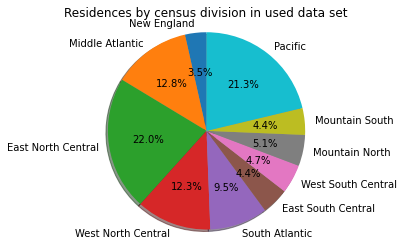

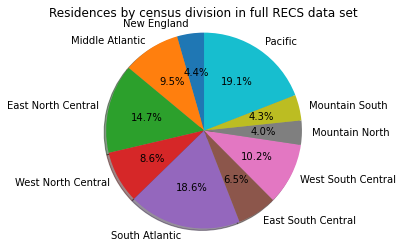

In [169]:
# Create a pie chart of data by census division for used data
# Count residences in each division
counts = np.empty(10)
for i in range(10):
    column_label = "DIVISION_{}".format(i+1)
    counts[i] = len(df_use[df_use[column_label] == 1])
# Create the pie chart
labels = ["New England", "Middle Atlantic", "East North Central", "West North Central", "South Atlantic",
          "East South Central", "West South Central", "Mountain North", "Mountain South", "Pacific"]
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Residences by census division in used data set")
plt.show()


# Create a pie chart of data by census division for all data
# Count residences in each division
counts = np.empty(10)
for i in range(10):
    counts[i] = len(df_all[df_all['DIVISION'] == (i + 1)])  
# Create the pie chart
labels = ["New England", "Middle Atlantic", "East North Central", "West North Central", "South Atlantic",
          "East South Central", "West South Central", "Mountain North", "Mountain South", "Pacific"]
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Residences by census division in full RECS data set")
plt.show()
    

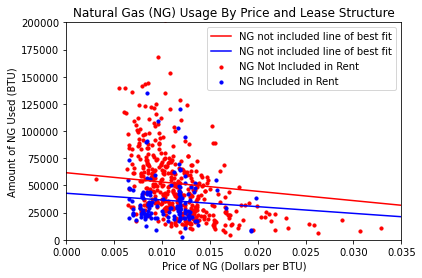

In [170]:
# Create a scatter plot showing NG use by NG price
df_included = df_use[df_use['NGINCLUDED'] == 1]
df_not_included = df_use[df_use['NGINCLUDED'] == 0]
plt.scatter(df_not_included['NGPRICE'], df_not_included['BTUNG'], s=10, color='red', label='NG Not Included in Rent')
a, b = np.polyfit(df_not_included['NGPRICE'], df_not_included['BTUNG'], 1)
x = np.linspace(0, 1, num=50)
plt.plot(x, a*x+b, color='red', label="NG not included line of best fit")
plt.scatter(df_included['NGPRICE'], df_included['BTUNG'], s=10, color='blue', label='NG Included in Rent')
a, b = np.polyfit(df_included['NGPRICE'], df_included['BTUNG'], 1)
plt.plot(x, a*x+b, color='blue', label="NG not included line of best fit")
plt.xlim([0, 0.035])
plt.ylim([0, 200000])
plt.title("Natural Gas (NG) Usage By Price and Lease Structure")
plt.xlabel("Price of NG (Dollars per BTU)")
plt.ylabel("Amount of NG Used (BTU)")
plt.legend()
plt.show()

In [171]:
# Print Table of Summary Statistics
summary_stats = []
headers = ["", "NG Included", "Count", "Mean", "STD"]
# For each data point, add summary statistics to the table
stat_of_interest = df_included['BTUNG'].describe()
summary_stats.append(["Amount of NG Used (BTU)", "Yes", stat_of_interest['count'], 
                      stat_of_interest['mean'], stat_of_interest['std']])
stat_of_interest = df_included['NGPRICE'].describe()
summary_stats.append(["NG Price (Dollars/BTU)", "Yes", stat_of_interest['count'], 
                      stat_of_interest['mean'], stat_of_interest['std']])

stat_of_interest = df_not_included['BTUNG'].describe()
summary_stats.append(["Amount of NG Used (BTU)", "No", stat_of_interest['count'], 
                      stat_of_interest['mean'], stat_of_interest['std']])
stat_of_interest = df_not_included['NGPRICE'].describe()
summary_stats.append(["NG Price (Dollars/BTU)", "No", stat_of_interest['count'], 
                      stat_of_interest['mean'], stat_of_interest['std']])


print(tabulate(summary_stats, headers=headers))

                         NG Included      Count           Mean            STD
-----------------------  -------------  -------  -------------  -------------
Amount of NG Used (BTU)  Yes                134  36312.7        21472.8
NG Price (Dollars/BTU)   Yes                134      0.0105331      0.0026163
Amount of NG Used (BTU)  No                 435  51147          33794.7
NG Price (Dollars/BTU)   No                 435      0.0123255      0.0102557


### OLS Regression

In [172]:
# Create tenant effective price column 
df_use['EFFNGPRICE'] = df_use['NGPRICE'] * (1 - df_use['NGINCLUDED'])

/var/folders/mf/q24ddnrs2xv45jj769zh4zb40000gn/T/ipykernel_57007/1891071109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use['EFFNGPRICE'] = df_use['NGPRICE'] * (1 - df_use['NGINCLUDED'])


In [173]:
# Normalize all observations between 0 and 1
df_norm = pd.DataFrame(index=df_use.index)
for column in df_use.columns:
    df_norm[column] = MinMaxScaler().fit_transform(np.array(df_use[column]).reshape(-1, 1))
    
# Create a constant column
df_norm['CONST'] = 1

# Create squared effecitve price column
df_norm['EFFNGPRICESQ'] = df_norm['EFFNGPRICE'] ** 2
# Create cubed effecitve price column
df_norm['EFFNGPRICECU'] = df_norm['EFFNGPRICE'] ** 3

# Create squared price column
df_norm['NGPRICESQ'] = df_norm['NGPRICE'] ** 2
# Create cubed price column
df_norm['NGPRICECU'] = df_norm['NGPRICE'] ** 3
    
df_norm

,YEARMADERANGE,MONEYPY,DIVISION_1,DIVISION_2,DIVISION_3,DIVISION_4,DIVISION_5,DIVISION_6,DIVISION_7,DIVISION_8,...,DIVISION_10,BTUNG,NGINCLUDED,NGPRICE,EFFNGPRICE,CONST,EFFNGPRICESQ,EFFNGPRICECU,NGPRICESQ,NGPRICECU
6,0.285714,0.428571,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.177104,0.0,0.059990,0.075360,1,0.005679,0.000428,0.003599,0.000216
20,0.000000,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.228574,0.0,0.061424,0.076771,1,0.005894,0.000452,0.003773,0.000232
21,0.428571,0.285714,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.343000,0.0,0.042393,0.058050,1,0.003370,0.000196,0.001797,0.000076
62,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.346652,0.0,0.030612,0.046462,1,0.002159,0.000100,0.000937,0.000029
72,0.857143,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.402983,0.0,0.022233,0.038221,1,0.001461,0.000056,0.000494,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,1.000000,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.296119,0.0,0.037150,0.052893,1,0.002798,0.000148,0.001380,0.000051
5660,0.000000,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.420944,0.0,0.022141,0.038129,1,0.001454,0.000055,0.000490,0.000011
5668,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.237233,1.0,0.032246,0.000000,1,0.000000,0.000000,0.001040,0.000034
5681,0.285714,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.087843,1.0,0.028212,0.000000,1,0.000000,0.000000,0.000796,0.000022


In [174]:
# Perform an OLS Regression of effective price and controls on NG usage
control_columns = ['MONEYPY']
regressor_columns = ['CONST', 'EFFNGPRICE', 'EFFNGPRICESQ', 'EFFNGPRICECU']

eff_results = sm.OLS(df_norm['BTUNG'], df_norm[regressor_columns + control_columns]).fit()
eff_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  BTUNG   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.379
Date:                Thu, 31 Mar 2022   Prob (F-statistic):            0.00171
Time:                        16:46:00   Log-Likelihood:                 371.59
No. Observations:                 569   AIC:                            -733.2
Df Residuals:                     564   BIC:                            -711.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CONST            0.1870      0.011     17.229      0.000       0.166       0.208
EFFNGPRICE       0.2213      0.245      0.905      0.366      -0.259       0.702
EFFNGPRICESQ    -4.1641      1.396     -2.982      0.003      -6.907      -1.422
EFFNGPRICECU     3.7856      1.245      3.041      0.002       1.341       6.230
MONEYPY          0.0244      0.020      1.198      0.231      -0.016       0.064
==============================================================================
Omnibus:                      225.793   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              949.787
Skew:                           1.786   Prob(JB):                    5.71e-207
Kurtosis:                       8.225   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [175]:
# Perform the same regression with the actual price
control_columns = ['MONEYPY']
regressor_columns = ['CONST', 'NGPRICE', 'NGPRICESQ', 'NGPRICECU']

act_results = sm.OLS(df_norm['BTUNG'], df_norm[regressor_columns + control_columns]).fit()

act_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  BTUNG   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     27.76
Date:                Thu, 31 Mar 2022   Prob (F-statistic):           4.64e-21
Time:                        16:46:01   Log-Likelihood:                 414.01
No. Observations:                 569   AIC:                            -818.0
Df Residuals:                     564   BIC:                            -796.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CONST          0.3258      0.016     20.550      0.000       0.295       0.357
NGPRICE       -3.7030      0.401     -9.246      0.000      -4.490      -2.916
NGPRICESQ      9.0820      1.682      5.400      0.000       5.779      12.385
NGPRICECU     -5.7082      1.386     -4.118      0.000      -8.431      -2.986
MONEYPY        0.0315      0.019      1.668      0.096      -0.006       0.068
==============================================================================
Omnibus:                      225.113   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1079.204
Skew:                           1.723   Prob(JB):                    4.51e-235
Kurtosis:                       8.800   Cond. No.                         460.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

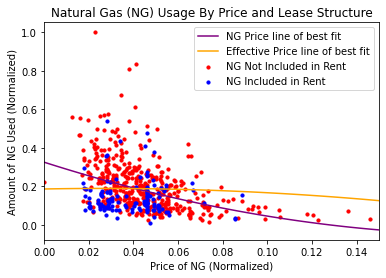

In [176]:
# Plot Curve of best fit

#Plot scatter plot
df_included = df_norm[df_norm['NGINCLUDED'] == 1]
df_not_included = df_norm[df_norm['NGINCLUDED'] == 0]
plt.scatter(df_not_included['NGPRICE'], df_not_included['BTUNG'], s=10, color='red', label='NG Not Included in Rent')
plt.scatter(df_included['NGPRICE'], df_included['BTUNG'], s=10, color='blue', label='NG Included in Rent')

plt.title("Natural Gas (NG) Usage By Price and Lease Structure")
plt.xlabel("Price of NG (Normalized)")
plt.ylabel("Amount of NG Used (Normalized)")
plt.xlim([0, 0.15])


# Plot curves of best fit
eff_params = eff_results.params
act_params = act_results.params

x_vals = np.linspace(0, 0.15, num=50)
eff_y = np.empty(50)
act_y = np.empty(50)
for i, x in enumerate(x_vals):
    eff_y[i] = eff_params['CONST'] + (x * eff_params['EFFNGPRICE']) + ((x ** 2) * eff_params['EFFNGPRICESQ'])
    + ((x ** 3) * eff_params['EFFNGPRICECU'])
    act_y[i] = act_params['CONST'] + (x * act_params['NGPRICE']) + ((x ** 2) * act_params['NGPRICESQ'])
    + ((x ** 3) * act_params['NGPRICECU'])
    
plt.plot(x_vals, act_y, color='purple', label='NG Price line of best fit')
plt.plot(x_vals, eff_y, color='orange', label='Effective Price line of best fit')
plt.legend()
plt.show()

### Multilayer Perceptron

In [177]:
# Split into testing and training data for effective price neural net
control_columns = ['MONEYPY']
regressor_columns = ['CONST', 'EFFNGPRICE']

x_train, x_test, y_train, y_test = train_test_split(df_norm[regressor_columns + control_columns], df_norm['BTUNG'], 
                                                    test_size=0.2)

# Train Multilayer Perceptron to estimate NG use based on effective price

eff_mlp = MLPRegressor(hidden_layer_sizes=(2,5,2), activation='logistic', solver='adam', max_iter =1000, learning_rate_init=0.01) 
eff_mlp.fit(x_train, y_train)

print("Effective Price Training R Squared: ", eff_mlp.score(x_train, y_train))
print("Effective Price Testing R Squared: ", eff_mlp.score(x_test, y_test))

Effective Price Training R Squared:  -0.009235217065662438
Effective Price Testing R Squared:  -0.06350978407537688


In [178]:
# Split into testing and training data for actual price neural net
control_columns = ['MONEYPY']
regressor_columns = ['CONST', 'NGPRICE']

x_train, x_test, y_train, y_test = train_test_split(df_norm[regressor_columns + control_columns], df_norm['BTUNG'], 
                                                    test_size=0.2)

# Train Multilayer Perceptron to estimate NG use based on actual price
act_mlp = MLPRegressor(hidden_layer_sizes=(2,5,2), activation='logistic', solver='adam', max_iter =1000, learning_rate_init=0.01) 
act_mlp.fit(x_train, y_train)

print("Actual Price Training R Squared: ", act_mlp.score(x_train, y_train))
print("Actual Price Testing R Squared: ", act_mlp.score(x_test, y_test))

Actual Price Training R Squared:  -0.0043851719182594895
Actual Price Testing R Squared:  -0.0030468129243985675


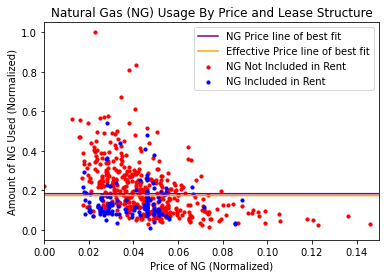

In [179]:
# Plot neural net estimates

#Plot scatter plot
df_included = df_norm[df_norm['NGINCLUDED'] == 1]
df_not_included = df_norm[df_norm['NGINCLUDED'] == 0]
plt.scatter(df_not_included['NGPRICE'], df_not_included['BTUNG'], s=10, color='red', label='NG Not Included in Rent')
plt.scatter(df_included['NGPRICE'], df_included['BTUNG'], s=10, color='blue', label='NG Included in Rent')

plt.title("Natural Gas (NG) Usage By Price and Lease Structure")
plt.xlabel("Price of NG (Normalized)")
plt.ylabel("Amount of NG Used (Normalized)")
plt.xlim([0, 0.15])


# Plot curves of best fit

x_vals = np.linspace(0, 0.15, num=50)
eff_y = np.empty(50)
act_y = np.empty(50)
avg_income = np.mean(df_norm['MONEYPY'])
for i, x in enumerate(x_vals):
    eff_y[i] = eff_mlp.predict([[1, x, avg_income]])
    act_y[i] = act_mlp.predict([[1, x, avg_income]])
    
plt.plot(x_vals, act_y, color='purple', label='NG Price line of best fit')
plt.plot(x_vals, eff_y, color='orange', label='Effective Price line of best fit')
plt.legend()
plt.show()